In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
random.seed(0)

In [4]:
df = pd.read_csv('SJ001_merge_1day.csv')
data = df.iloc[:, 1:].values
for i in range(len(data)):
    if data[i, 2] > 500:
        data[i, 2] = (data[i-1, 2] + data[i+1, 2])/2 

data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

In [5]:
interval = 97
input_size = data.shape[1]

total_num = 8000
train_num = 7000
test_num = 1000

input_series = np.zeros((train_num + test_num, interval, input_size))
target_series = np.zeros((train_num + test_num, interval, 1))

for i in range(train_num + test_num):
    input_series[i, :, :] = data[i: i+interval]
    target_series[i, :, :] = data[i+interval: i+interval*2, 2:3]

input_series = torch.from_numpy(input_series).to(device)
target_series = torch.from_numpy(target_series).to(device)
    
X_train = input_series[:train_num]
X_test = input_series[train_num: train_num + test_num]
y_train = target_series[:train_num]
y_test = target_series[train_num: train_num + test_num]

In [6]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first = True)

    def forward(self, input, hidden):
        batch_size, seq_len = input.shape[0], input.shape[1]
        output = input.float()
        hidden = hidden.float()
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self, batch_size=1):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

In [8]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first = True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        output = input.view(batch_size, 1, 1).float()
        hidden = hidden.float()
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        
        return output, hidden    

In [9]:
hidden_size = 128
encoder1 = EncoderRNN(input_size, hidden_size).to(device)
decoder1 = DecoderRNN(1, hidden_size, 1).to(device)

In [17]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    
    batch_size = input_tensor.size(0)
    encoder_hidden = encoder.initHidden(batch_size = batch_size)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(1)
    target_length = target_tensor.size(1)


    encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)
    
    decoder_input = input_tensor[:, -1:, 2:3]
    decoder_hidden = encoder_hidden
    outputs = []
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
#     outputs, _ = decoder(decoder_input, decoder_hidden, target_length)

    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            outputs.append(decoder_output.squeeze(0))
            decoder_input = target_tensor[:, di:di+1, :] # Teacher forcing
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            outputs.append(decoder_output.squeeze(0))
            decoder_input = decoder_output              
            
    outputs = torch.stack(outputs, dim=1).view(batch_size, target_length, 1)
#     loss += criterion(decoder_output, target_tensor.float())

    loss = criterion(outputs, target_tensor.float())

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [18]:
def trainIters(encoder, decoder, batch_size = 40, epoch = 100, n_iters=train_num, print_every=1000, plot_every=100, learning_rate=0.005):
    plot_losses = []

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    for ep in range(epoch):
        loss = 0
        
        for b in range(int(train_num / batch_size)):
            input_tensor = input_series[batch_size*b:batch_size*(b+1)]
            target_tensor = target_series[batch_size*b:batch_size*(b+1)]

            loss += train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        loss = loss/ int(train_num / batch_size)    
        plot_losses.append(loss)
        print("Epoch ", ep, "MSE: ", loss)

In [19]:
trainIters(encoder1, decoder1, epoch=150)

Epoch  0 MSE:  0.0005757172389809094
Epoch  1 MSE:  0.0004414319727893516
Epoch  2 MSE:  0.0004247001311926931
Epoch  3 MSE:  0.00043893381407339015
Epoch  4 MSE:  0.00044356235637657386
Epoch  5 MSE:  0.00040303506304143713
Epoch  6 MSE:  0.00027494676729365204
Epoch  7 MSE:  0.00030636136944025785
Epoch  8 MSE:  0.00023549114964320836
Epoch  9 MSE:  0.0001968154547645523
Epoch  10 MSE:  0.00021745640397708278
Epoch  11 MSE:  0.0002046723314115178
Epoch  12 MSE:  0.00015712832845473157
Epoch  13 MSE:  0.0001534525268273607
Epoch  14 MSE:  0.0001404121945185562
Epoch  15 MSE:  0.000153191018896246
Epoch  16 MSE:  0.0001554207117207601
Epoch  17 MSE:  0.0001426807028928632
Epoch  18 MSE:  0.0001518500047949841
Epoch  19 MSE:  0.0001500751126958098
Epoch  20 MSE:  0.0001426216517815117
Epoch  21 MSE:  0.00015316723626784557
Epoch  22 MSE:  0.00014683083468219684
Epoch  23 MSE:  0.00014175472070568617
Epoch  24 MSE:  0.00013566923960055808
Epoch  25 MSE:  0.00013448865917224618
Epoch  26 

In [34]:
def evaluate(encoder, decoder, input_tensor, target_length):
    with torch.no_grad():
        input_tensor = input_tensor.unsqueeze(0)
        input_length = input_tensor.size()[1]
        encoder_hidden = encoder.initHidden(batch_size = 1)

        encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)

        decoder_input = input_tensor[:, -1:, 2:3] 
        decoder_hidden = encoder_hidden
        
        decoded = []
        
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            decoded.append(decoder_output.item())
            decoder_input = decoder_output
        return decoded

In [32]:
input_series[570].unsqueeze(0).shape

torch.Size([1, 97, 12])

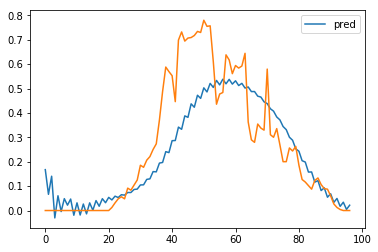

In [35]:
dec = evaluate(encoder1, decoder1, input_series[570], interval)
plt.plot(dec, label = 'pred')
plt.plot(target_series[570].cpu().numpy())
plt.legend()

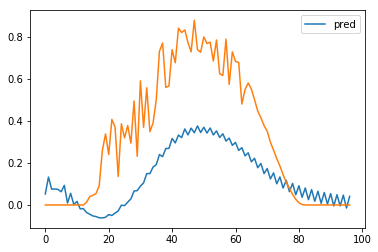

In [36]:
dec = evaluate(encoder1, decoder1, input_series[1630], interval)
plt.plot(dec, label = 'pred')
plt.plot(target_series[1630].cpu().numpy())
plt.legend()